In [37]:
import pandas as pd
import networkx as nx
import numpy as np
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import pickle
from os.path import exists
from math import ceil
from copy import deepcopy
from scipy.integrate import solve_ivp
from itertools import combinations_with_replacement
from emn_model import (
    get_clean_dataset, generate_bipartite_network, diffusion_dynamics, tree_project_network
)

TEX_PLOTS = True

# Plotting config
if TEX_PLOTS:
    plt.rc("text", usetex=True)
    plt.rc("font", family="serif")
    plt.rc("text.latex", preamble=r"""
         \usepackage{times}
         \usepackage{mathptmx}
         \usepackage{siunitx}""")
else:
    plt.rc("text", usetex=False)

mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["font.size"] = 14
mpl.rcParams["axes.labelsize"] = mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.2
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["lines.linewidth"] = 1

cmap = mpl.cm.get_cmap("Dark2")
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=cmap.colors)

np.random.seed(1231)
NPZ_DIR = "data"

def get_save_path(path):
    # I hate myself
    while path[0] == '/':
        path = path[1:]
        
    return f"{NPZ_DIR}/{path}"



In [57]:
def avg_degree_ne(node_count, edge_count):
    """Not to be confused with degree centrality."""
    return 2 * edge_count / node_count

def avg_degree(G):
    """Not to be confused with degree centrality"""
    return avg_degree_ne(len(G.nodes), len(G.edges))

def list_map(f, xs):
    """Yeah"""
    return list(map(f, xs))

def array_map(f, xs):
    """LOL"""
    return np.array(list_map(f, xs))

def split3(xs, N):
    """A 3D system is three 1D systems"""
    return np.array(xs[:N]), np.array(xs[N:2*N]), np.array(xs[2*N:])

def mean_std(xs):
    return np.mean(xs), np.std(xs)

In [39]:
df = get_clean_dataset()
B = generate_bipartite_network(df)
G = tree_project_network(B)
pos = nx.spring_layout(G, k=3, seed=99192, weight=None)

In [40]:
N = len(G.nodes)

plant_carbon_0 = np.array(list(nx.get_node_attributes(G, "carbon_value").values()))
root_carbon_0 = 0.1 * plant_carbon_0
plant_diameter_0 = np.array(list(nx.get_node_attributes(G, "diameter").values()))

t_range = (0, 16_000)
D_C = 5.0e-4 # carbon diffusion coeff
uptake_ps = (0.55, 0.0, 55.0)
f = 5.0e-4 # sensitive w.r.t plant carbon deposition
k = 0.6
g = 0.004
c = 0.82
rho = 0.01

sol = solve_ivp(diffusion_dynamics, t_range, np.concatenate([root_carbon_0, plant_carbon_0, plant_diameter_0]),
                args=(G, D_C, N, uptake_ps, f, k, c, g, rho), dense_output=True, method="BDF")

time_steps = 300
t = np.linspace(t_range[0], t_range[1], time_steps)
z = sol.sol(t)

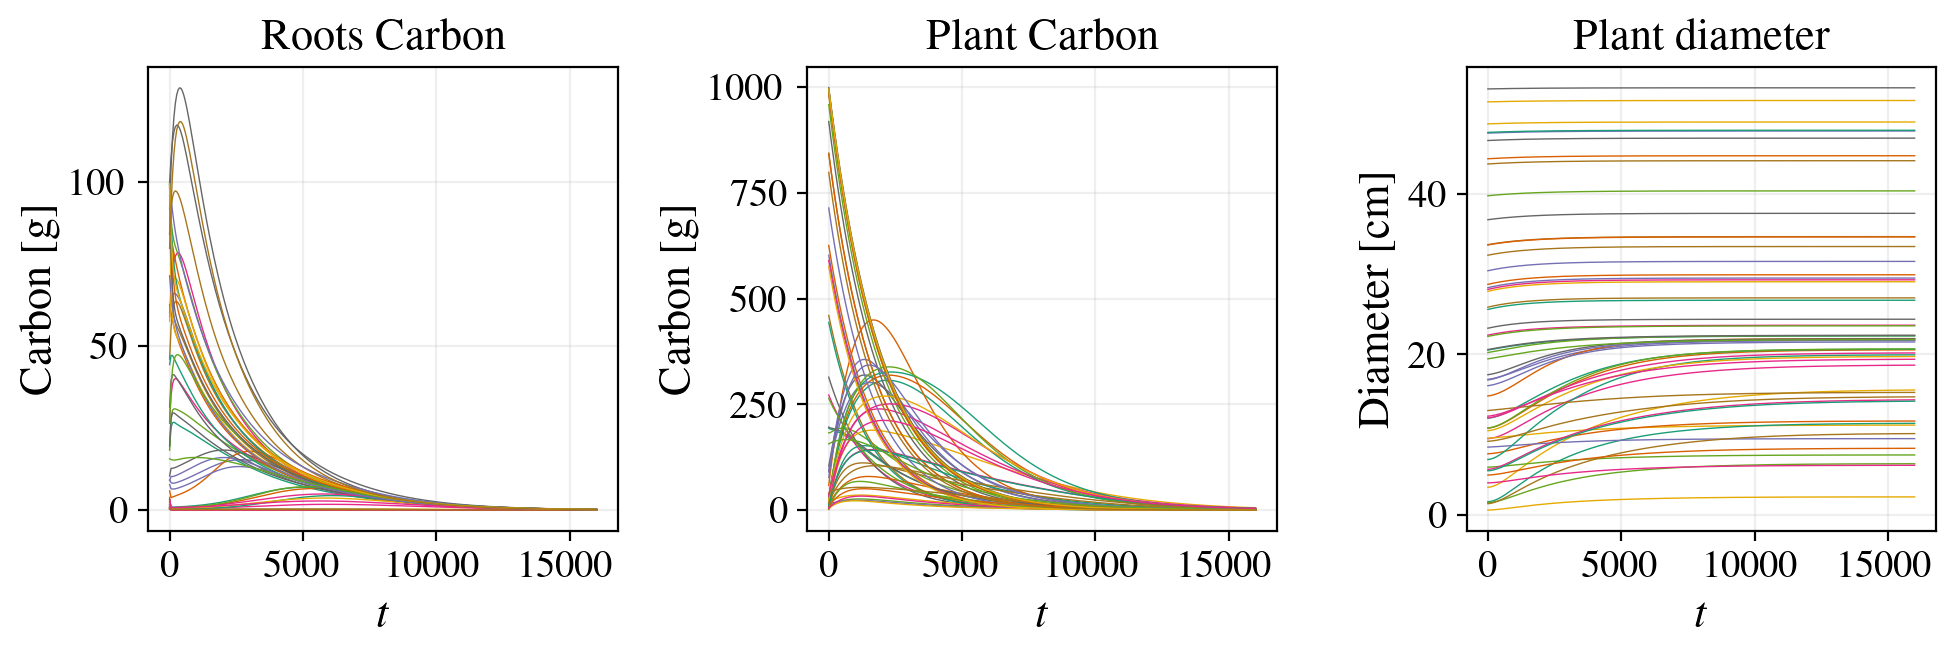

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), dpi=200)

axes[0].set_title("Roots Carbon")
for i in range(N):
    axes[0].plot(t, z[i], linewidth=0.5)
    axes[0].set_ylabel("Carbon [g]")
    
axes[1].set_title("Plant Carbon")
for i in range(N, 2*N):
    axes[1].plot(t, z[i], linewidth=0.5)
    axes[1].set_ylabel("Carbon [g]")
    
axes[2].set_title("Plant diameter")
for i in range(2*N, 3*N):
    axes[2].plot(t, z[i], linewidth=0.5)
    axes[2].set_ylabel("Diameter [cm]")
    #axes[2].set_yscale("log")
    
for ax in axes:
    ax.set_xlabel("$t$")

plt.tight_layout()
plt.show()

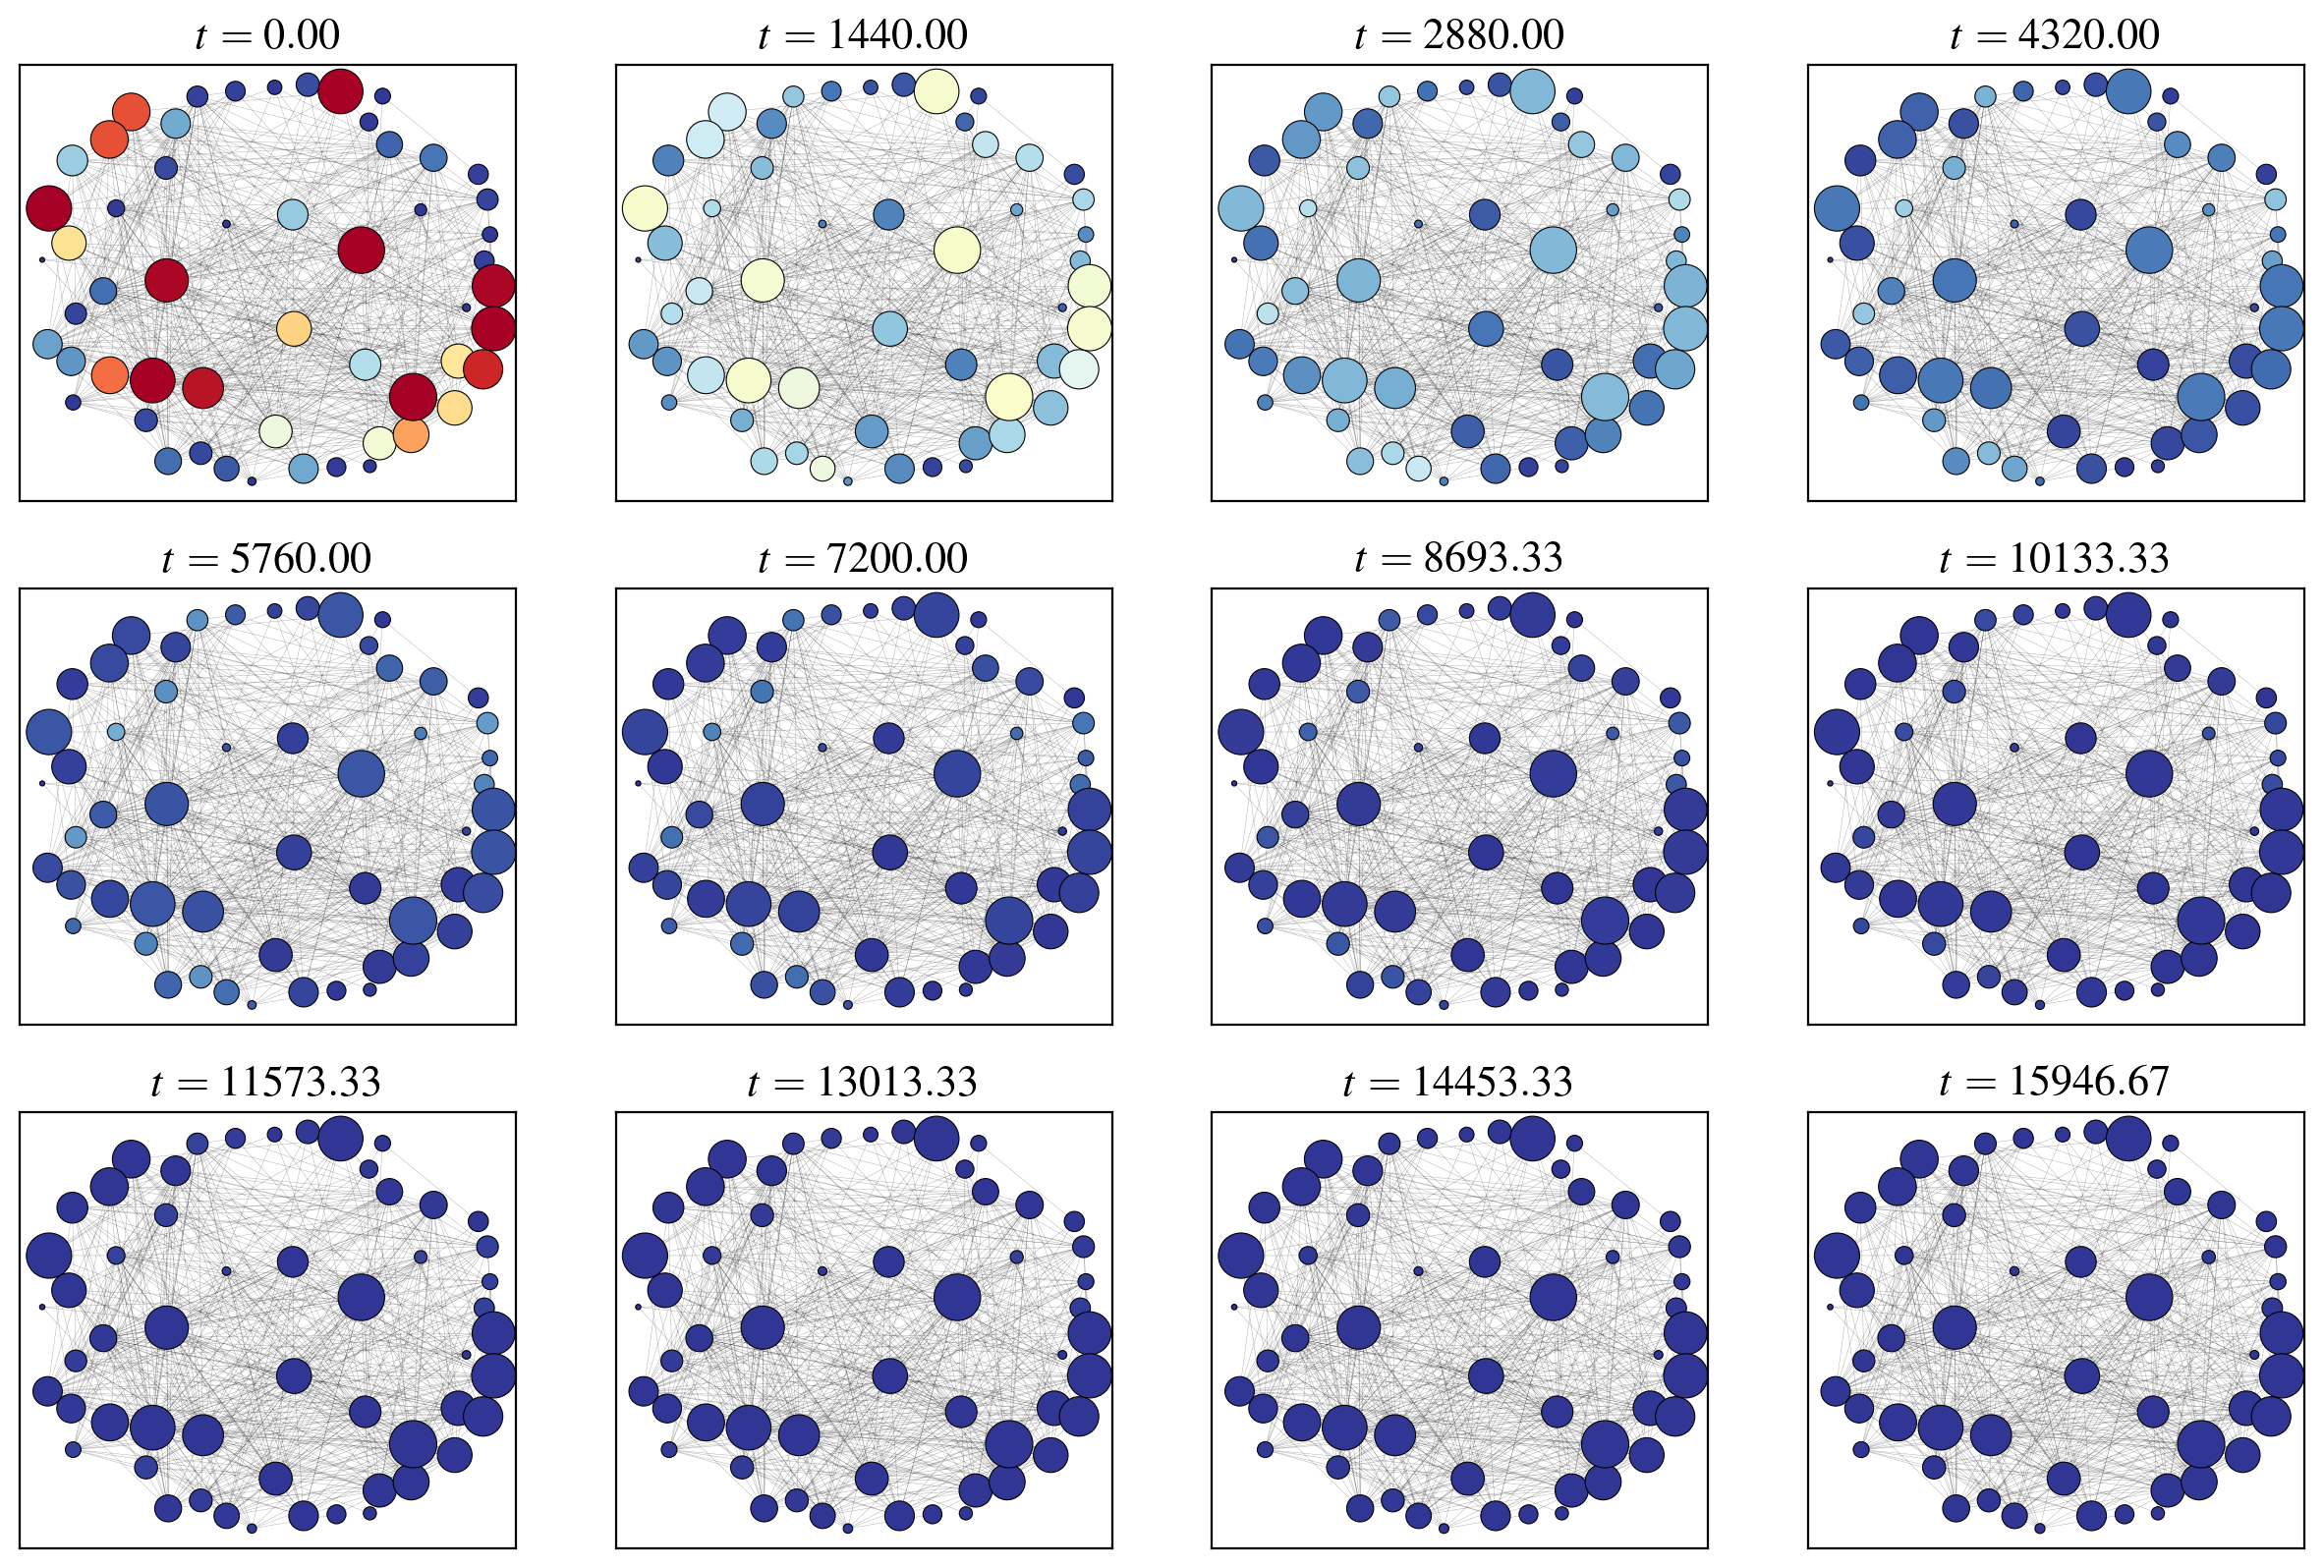

In [42]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))

steps = np.linspace(0, time_steps-1, 12, dtype=int)

plant_carbon_data = z[N:2*N,:]
min_carbon, max_carbon = np.min(plant_carbon_data), np.max(plant_carbon_data)

diameter_data = z[2*N:,:]
max_diameter = np.max(diameter_data)

nodes_by_cohort = {"Sapling": [], "Maturing": [], "Established": []}
node_list = list(G.nodes)

for node in G.nodes:
    nodes_by_cohort[G.nodes[node]["cohort"]].append(node)

for j, ax in enumerate(axes.flat):
    ax.set_title(f"$t = {(steps[j])*t_range[1]/time_steps:.2f}$")
    ax.grid(False)
    
    roots_carbon_vals_t = z[:,steps[j]][:N]
    plant_carbon_vals_t = z[:,steps[j]][N:2*N]
    diameter_vals_t = (z[:,j][2*N:3*N])/max_diameter*300
#     diameter_vals_log = np.log(1+diameter_vals_t)*50
    
    edges = nx.draw_networkx_edges(G, pos, alpha=0.35, width=[0.15 for _ in range(len(G.nodes))], ax=ax)
    edges.set_zorder(-1)
    
    # set correct z-index for nodes so small nodes don't get hidden behind big nodes. hacky but works :)
    for cohort, nodes in nodes_by_cohort.items():
        H = G.subgraph(nodes)
        node_idxs = [node_list.index(node) for node in nodes]
        collection = nx.draw_networkx_nodes(
            H, pos=pos, node_size=diameter_vals_t[node_idxs], node_color=plant_carbon_vals_t[node_idxs],
            edgecolors="black", linewidths=0.4, cmap=mpl.cm.RdYlBu_r, ax=ax, vmin=min_carbon, vmax=max_carbon)
#         collection.set_zorder(4-cohort)
    
plt.show()

In [43]:
def max_growth_diff(percentages):
    perms = itertools.permutations(percentages, 2)
    diffs = np.array([np.abs(a - b) for a, b in perms])

    return np.max(diffs)

In [44]:
def excess_edges(G, target_avg_degree):
    """
    For graph `G`, count the number of edges that should be removed to
    get closer to get an average degree of `target_avg_degree`.
    
    The resulting value should give a graph that is either the closest or
    second closest to the avergae degree.
    """
    k_avg = avg_degree(G)
    excess_avg_degree = (k_avg - target_avg_degree)
    excess = round(excess_avg_degree * len(G.nodes)/2)
    return excess

In [48]:
target_avg_degrees = np.linspace(0.2, 16.0, 11)
n_edge_remove_list = list(map(lambda x: excess_edges(G, x), target_avg_degrees))

reps = 5
# initialise empty results
remove_results = {
    k: {
        "networks": [],
        "data": []
    }
    for k in n_edge_remove_list
}

network_edges = list(G.edges)

node_count = len(G.nodes)
        
# initial values
plant_carbon_0 = np.array(list(nx.get_node_attributes(G, "carbon_value").values()))
root_carbon_0 = 0.1 * plant_carbon_0
plant_diameter_0 = np.array(list(nx.get_node_attributes(G, "diameter").values()))

t_range = (0, 16_000)
# system parameters
D_C = 5.0e-4 # carbon diffusion coeff
uptake_ps = (0.55, 0.0, 55.0)
f = 5.0e-4 # sensitive w.r.t plant carbon deposition
k = 0.6
g = 0.004
c = 0.82
rho = 0.01
time_steps = 301
ts = np.linspace(*t_range, time_steps)
save_path = get_save_path("diffusion_time_scales.npz")

if not exists(save_path):
    for j, n_edge_remove in enumerate(n_edge_remove_list):
        print(f"node_count {j+1}/{len(n_edge_remove_list)}")
        for i in range(reps):
            # copy original graph and remove some edges
            G_r = deepcopy(G)
            edges_idx = np.random.choice(len(network_edges), size=n_edge_remove, replace=False)

            G_r.remove_edges_from([network_edges[edge_idx] for edge_idx in edges_idx])
            remove_results[n_edge_remove]["networks"].append(G_r)

            sol = solve_ivp(diffusion_dynamics, t_range,
                            np.concatenate([root_carbon_0, plant_carbon_0, plant_diameter_0]),
                            args=(G_r, D_C, node_count, uptake_ps, f, k, c, g, rho), dense_output=True, method="BDF")
            z = sol.sol(t)
            remove_results[n_edge_remove]["data"].append(z)
else:
    with open(save_path, "rb") as f:
        remove_results = pickle.load(f)

node_count 1/11
node_count 2/11
node_count 3/11
node_count 4/11
node_count 5/11
node_count 6/11
node_count 7/11
node_count 8/11
node_count 9/11
node_count 10/11
node_count 11/11


In [90]:
node_count = len(G.nodes)
edge_count = len(G.edges)
actual_avg_degrees = np.array([2 * (edge_count - n_edge_rmv)/node_count for n_edge_rmv in n_edge_remove_list])

names = ["roots", "plants", "biomass"]
holy_shit_so_many_identifiers = {name: [[],[]] for name in names}

# TODO: do not hard-code this
N = 55
# for each average degree
for n_edge_rmv, data in remove_results.items():
    timeseries_data = np.array(data["data"])  # great identifier naming
    roots, plants, biomass = timeseries_data[:,:N,:], timeseries_data[:,N:2*N:,:], timeseries_data[:,2*N:,:]
    for name, component in zip(names, [roots, plants, biomass]):
        # TODO: consider changing variance to standard deviation?
        # alternatively, just fit an exponential curve thingy to the guys
        inter_node_variance_data = np.array([np.var(xs, axis=1) for xs in component])
        c_times = np.std(inter_node_variance_data, axis=1)
        μ, σ = mean_std(c_times)
        holy_shit_so_many_identifiers[name][0].append(μ)
        holy_shit_so_many_identifiers[name][1].append(σ)
    
for k,v in holy_shit_so_many_identifiers.items():
    holy_shit_so_many_identifiers[k] = np.array(v)

In [91]:
holy_shit_so_many_identifiers

{'roots': array([[15078.4670381 ,  8635.52045832,  5853.38825832,  3230.12890315,
          2411.92664171,  1491.74272827,  1490.24021234,   759.88841005,
           580.55786643,   406.85256466,   449.07324842],
        [  525.28297133,  1394.56452812,  1222.3246465 ,  1017.13346242,
          1016.43354617,   373.94261116,   684.09557424,   171.22498225,
            50.51167152,    26.54241606,    80.08385976]]),
 'plants': array([[17442.24994138, 17260.0614767 , 17038.12668132, 16987.68592947,
         16686.21451843, 16294.36768654, 16382.12869311, 16329.38675054,
         16190.90677554, 16203.35808135, 16179.20754461],
        [   32.35669131,   368.25715581,   401.09816816,   226.56174088,
           157.96732778,    48.77681417,    94.94431863,    66.02203131,
            51.08880157,    75.4142104 ,    37.49261619]]),
 'biomass': array([[1.34525171, 4.08573037, 4.81356828, 4.45093336, 4.48713648,
         4.19510826, 3.58964392, 3.83273419, 3.52302994, 3.47478158,
         3.4

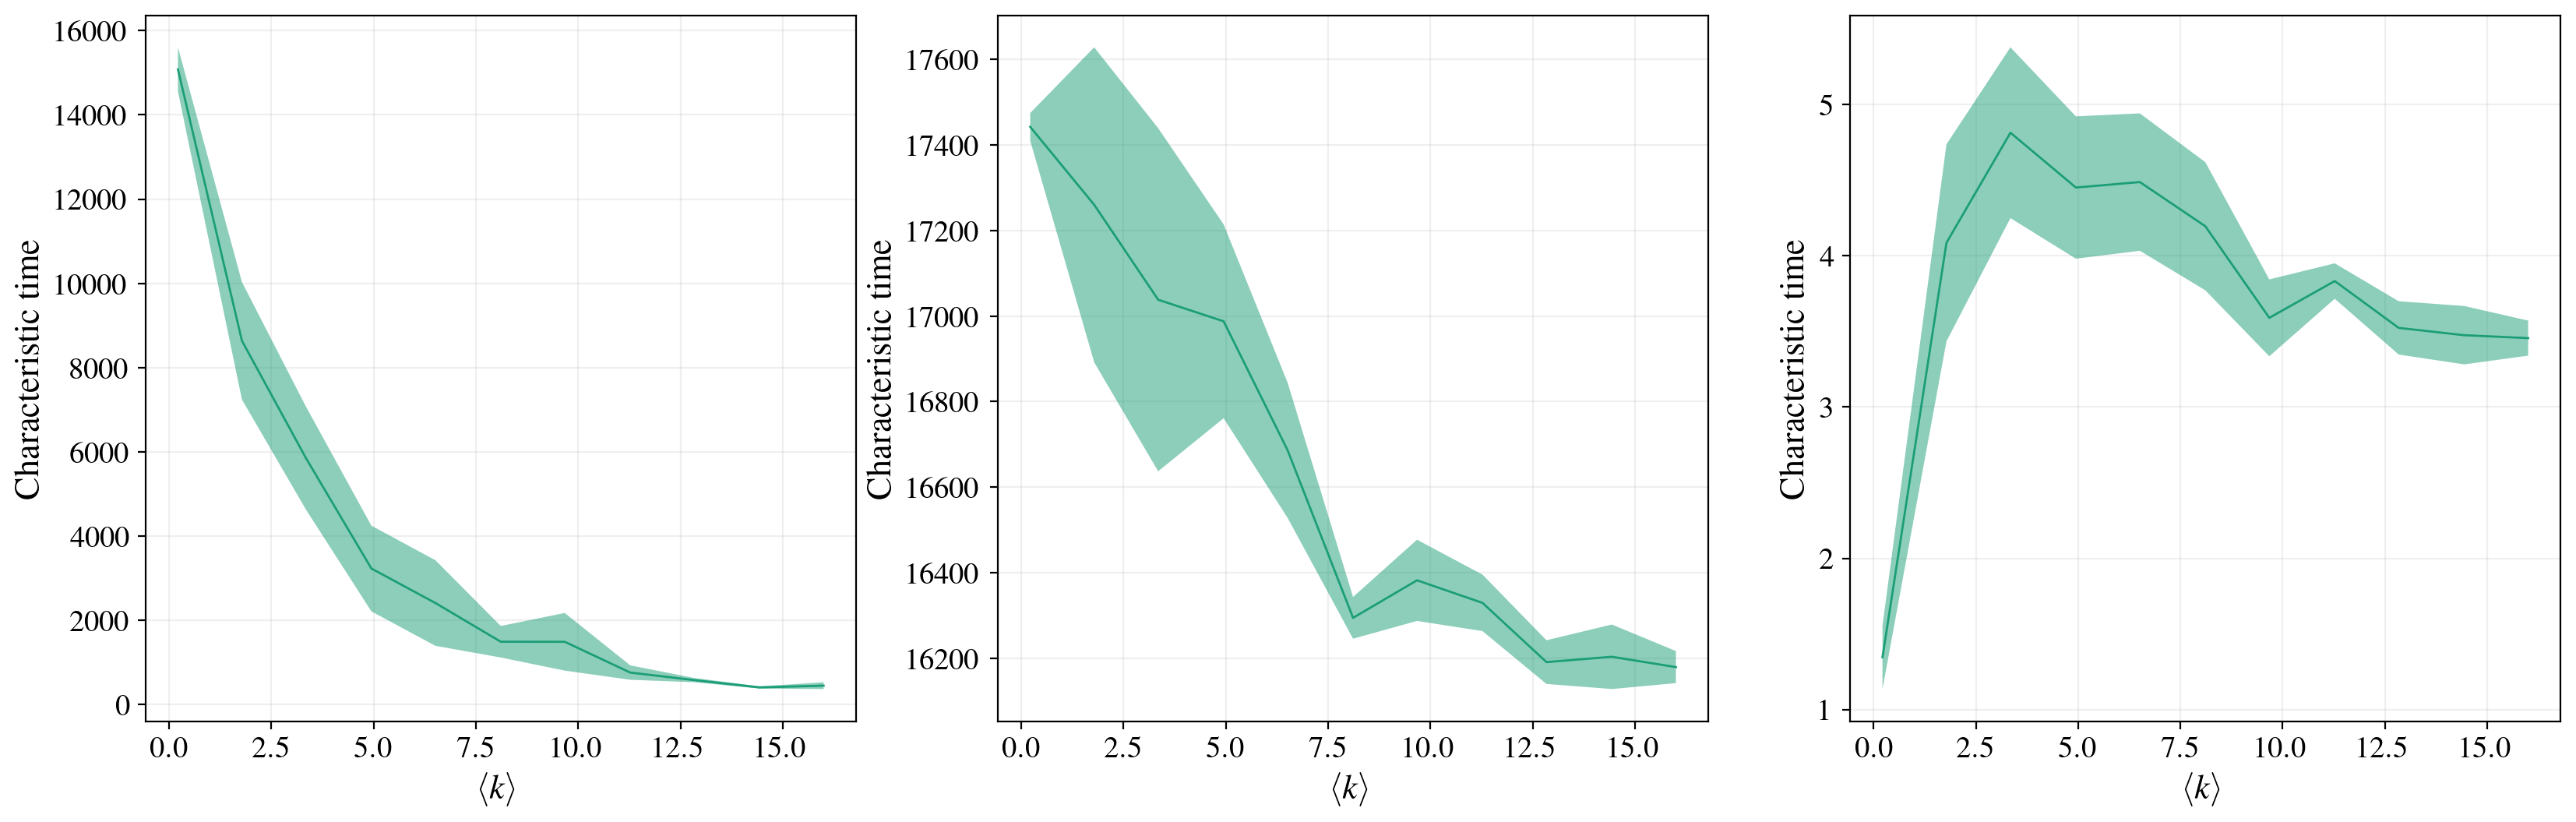

In [100]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
labels=["roots", "plants", "biomass"]
for (k, μσ), ax in zip(holy_shit_so_many_identifiers.items(), axes):
    ax.set_title(k)
    ax.plot(actual_avg_degrees, μσ[0])
    ax.fill_between(actual_avg_degrees, μσ[0] - μσ[1], μσ[0] + μσ[1], alpha=0.5)
    ax.set_ylabel("Characteristic time")
    ax.set_xlabel("$\\langle k \\rangle$")
    
plt.show()

In [ ]:
x = []
ys = {k : [] for k in ["Sapling", "Maturing", "Established"]}
errs = {k : [] for k in ["Sapling", "Maturing", "Established"]}

for n, data in remove_results.items():
    avg_degree = np.mean(list(dict(data["networks"][0].degree()).values()))
    x.append(avg_degree)
    for cohort, nodes in nodes_by_cohort.items():
        node_idxs = [node_list.index(node) for node in nodes]
        
        growth_percentages = []
        for run in data["data"]:
            diameter_data_run = run[2*N:,:]
            growth = diameter_data_run[node_idxs,-1] - diameter_data_run[node_idxs,0]
            growth_percentages.append(growth)

        concat_growth = np.concatenate(growth_percentages)
        
        ys[cohort].append(np.mean(concat_growth))
        errs[cohort].append(np.std(concat_growth))

In [ ]:
plt.figure(figsize=(5, 4))

for k in ys.keys():
    plt.errorbar(x, ys[k], errs[k], marker="o", ms=3, elinewidth=0.7, capthick=0.5, capsize=2, label=f"{k}")
    
plt.legend()
plt.xlabel(r"$\langle k \rangle$")
plt.ylabel(r"$\langle \Delta d_i \rangle$ [cm]")
plt.show()

In [ ]:
surv_ys = {k : [] for k in ["Sapling", "Maturing", "Established"]}
surv_errs = {k : [] for k in ["Sapling", "Maturing", "Established"]}

for n, data in remove_results.items():
    cohort = "Sapling"
    nodes = nodes_by_cohort[cohort]

    node_idxs = [node_list.index(node) for node in nodes]

    n_survivors_all = []
    for run in data["data"]:
        diameter_data_run = run[2*N:,:]
        growth_frac = diameter_data_run[node_idxs,-1]/diameter_data_run[node_idxs,0]
        n_survivors = len(np.where(growth_frac >= 2)[0])
        n_survivors_all.append(n_survivors)
    n_survivors_all = np.array(n_survivors_all)

    surv_ys[cohort].append(np.mean(n_survivors_all))
    surv_errs[cohort].append(np.std(n_survivors_all))

In [ ]:
plt.figure(figsize=(5, 4))

plt.errorbar(x, surv_ys["Sapling"], surv_errs["Sapling"], marker="o", ms=3, elinewidth=0.7, capthick=0.5, capsize=2)
    
plt.xlabel(r"$\langle k \rangle$")
plt.ylabel(r"$n$ Successful Saplings")
plt.show()

In [ ]:
for cohort, nodes in nodes_by_cohort.items():
    node_idxs = [node_list.index(node) for node in nodes]
    growth = diameter_data[node_idxs, -1] - diameter_data[node_idxs, 0]
    avg_growth = np.mean(growth)
    percentages = diameter_data[node_idxs, -1]/diameter_data[node_idxs, 0]*100
    percentage_mean = np.mean(percentages)
    percentage_stdev = np.std(percentages)

    print(f"Cohort {str(cohort)} grew on average {avg_growth} cm")
    print(f"Cohort {str(cohort)} grew on average {percentage_mean}% +- {percentage_stdev}")
    
    if cohort != 1:
        growth_diff = max_growth_diff(percentages)
        print(f"Cohort {str(cohort)} max growth difference (competition) {growth_diff}%")
        
#     print(percentages)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), dpi=200)

    roots_carbon_data = z[:N,:]
    plant_carbon_data = z[N:2*N,:]

    axes[0].set_title("Roots Carbon")
    axes[0].plot(t, roots_carbon_data[node_idxs, :].T, linewidth=0.5)
    axes[0].set_xlabel("$t$")
    axes[0].set_ylabel("Carbon [g]")

    axes[1].set_title("Plant Carbon")
    axes[1].plot(t, plant_carbon_data[node_idxs, :].T, linewidth=0.5)
    axes[1].set_xlabel("$t$")
    axes[1].set_ylabel("Carbon [g]")

    axes[2].set_title("Plant diameter")
    axes[2].plot(t, diameter_data[node_idxs, :].T, linewidth=0.5)
    axes[2].set_xlabel("$t$")
    axes[2].set_ylabel("Diameter [cm]")
    # axes[2].set_yscale("log")

    plt.tight_layout()
    plt.show()

In [ ]:
def animate_frames(zs, folder):
    import gc
    
    for j in range(time_steps):
        filename = f"movie_frames/{folder}/{j:04}.png"
        fig, ax = plt.subplots(figsize=(5, 4), dpi=200)

        ax.set_title(f"$t = {j*t_range[1]/time_steps:.2f}$")
        roots_carbon_vals_t = zs[:,j][:N]
        plant_carbon_vals_t = zs[:,j][N:]
        nx.draw_networkx_nodes(G, pos=pos, node_size=node_sizes, node_color=plant_carbon_vals_t,
                           edgecolors="black", linewidths=0.3, cmap=mpl.cm.coolwarm, ax=ax, vmin=0, vmax=10)
        nx.draw_networkx_edges(G, pos, alpha=0.4, width=[0.2 for _ in range(len(G.nodes))], ax=ax)
        plt.tight_layout()
        plt.gca().set_axis_off()
        plt.savefig(filename, facecolor='white', transparent=False)

        # https://stackoverflow.com/questions/7101404/how-can-i-release-memory-after-creating-matplotlib-figures
        plt.clf()
        plt.close()
        gc.collect()
        
# animate_frames(z, "source_sink")